# Envelopes Strategy

### Example of 100 candles of 15 min

In [1]:
#!pip install oandapyV20

In [2]:
#!pip install zulu

In [3]:
#!pip install mpl_finance

In [1]:
import numpy as np
import pandas as pd
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import datetime
import zulu
import os

pd.set_option('display.float_format', '{:.4f}'.format)

In [3]:
ID = '101-004-9949998-001'
token = '4900a27fe17ab573d490ce234465329f-6633f44d08bf25b48ceaacd2c7917674'

In [4]:
client = oandapyV20.API(access_token=token)

## Just an example with 100 rates

In [7]:
params = {
          "count": 100,
          "granularity": "M15"}

In [8]:
r = instruments.InstrumentsCandles(instrument="EUR_USD",
                                   params=params)

In [9]:
rv = client.request(r)

In [10]:
dat = []
for oo in r.response['candles']:
    dat.append([oo['time'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c']])

In [11]:
df = pd.DataFrame(dat)
df.columns = ['Time', 'Open', 'High', 'Low', 'Close']
df["Time"] = pd.to_datetime(df['Time'])
df['Time'] = df['Time'].apply(mpl_dates.date2num)
df = df.astype(float)
#df = df.set_index('Time')
df.head()

,Time,Open,High,Low,Close
0,737531.8333,1.0846,1.0847,1.0838,1.0838
1,737531.8438,1.0838,1.0838,1.0834,1.0834
2,737531.8542,1.0834,1.0835,1.0830,1.0831
3,737531.8646,1.0831,1.0841,1.0831,1.0839
4,737531.8750,1.0839,1.0840,1.0835,1.0838


In [12]:
plt.style.use('ggplot')

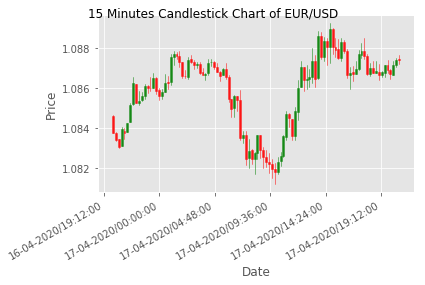

In [13]:
# Creating Subplots
fig, ax = plt.subplots()

candlestick_ohlc(ax, df.values, width=0.007, colorup='green', colordown='red', alpha=0.8)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('15 Minutes Candlestick Chart of EUR/USD')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y/%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()

plt.show()

# Envelope strategy on EURUSD

In [5]:
# Loop to create the dataset

Date = pd.Series(datetime.datetime(2010, 4, 1, 0, 0, 0))
eurusd = pd.DataFrame()


while Date.iloc[-1].year != 2020 or Date.iloc[-1].month != 4:
    
    last = Date.iloc[-1]
    inizio = last + datetime.timedelta(minutes=15)
    inizio = zulu.create(inizio.year, inizio.month, inizio.day, inizio.hour, inizio.minute)
    inizio = inizio.isoformat('T')+'Z'
    inizio = str(inizio[:-8] + 'Z')

    params = {
            "from": inizio,
            "granularity": "M15"}

    r = instruments.InstrumentsCandles(instrument="EUR_USD",
                                       params=params)

    rv = client.request(r)

    newDat = []
    for oo in r.response['candles']:
        newDat.append([oo['time'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c']])
    
    newEurusd = pd.DataFrame(newDat)
    newEurusd.columns = ['Time', 'Open', 'High', 'Low', 'Close']
    newEurusd["Time"] = pd.to_datetime(newEurusd['Time'])
    Date = Date.append(newEurusd['Time'])
    newEurusd['Time'] = newEurusd['Time'].apply(mpl_dates.date2num)
    newEurusd = newEurusd.astype(float)
    eurusd = eurusd.append(newEurusd)
    
#Adjusting so that eurusd and Date match
Date = Date.drop(index=0)
eurusd = eurusd.drop(index=0)

eurusd.index = range(eurusd.shape[0])
Date.index = range(eurusd.shape[0])

eurusd.head()

,Time,Open,High,Low,Close
0,733863.0208,1.3552,1.3554,1.3544,1.3546
1,733863.0312,1.3546,1.3547,1.3526,1.3530
2,733863.0417,1.3530,1.3530,1.3518,1.3518
3,733863.0521,1.3518,1.3520,1.3512,1.3517
4,733863.0625,1.3517,1.3517,1.3507,1.3514


In [6]:
#First and Last Day of the dataset
print(eurusd.shape)
print(Date.iloc[0])
print(Date.iloc[-1])
print(eurusd.head(5))

(250997, 5)
2010-04-01 00:30:00
2020-04-01 22:15:00
         Time   Open   High    Low  Close
0 733863.0208 1.3552 1.3554 1.3544 1.3546
1 733863.0312 1.3546 1.3547 1.3526 1.3530
2 733863.0417 1.3530 1.3530 1.3518 1.3518
3 733863.0521 1.3518 1.3520 1.3512 1.3517
4 733863.0625 1.3517 1.3517 1.3507 1.3514


In [8]:
#Export and Import the dataset
#eurusd.to_csv(os.getcwd()+'\\eurusd15min.csv')
eurusd = pd.read_csv(os.getcwd()+'\\eurusd15min.csv', index_col=0)

#Date.to_csv(os.getcwd()+'\\eurusd15minTime.csv')
Date = pd.read_csv(os.getcwd()+'\\eurusd15minTime.csv', header=None, index_col=0)
Date = Date.iloc[:,0]

### Definition of the Envelopes

In [10]:
def ENV(rates, period, deviation):
    UL=[]
    LL=[]
    ML = []
    
    SMA = eurusd['Close'].rolling(period).mean()
    
    for eachsma in SMA:
        uls = eachsma + (eachsma*deviation)
        lls = eachsma - (eachsma*deviation)
        mls = eachsma
        
        UL.append(uls)
        LL.append(lls)
        ML.append(mls)
        
    return period, UL, LL, ML 

In [11]:
period, ul0025, ll0025, ml = ENV(eurusd, 40, 0.0015)

eurusd["ml"] = ml
eurusd["ul0025"] = ul0025
eurusd["ll0025"] = ll0025

eurusd = eurusd.iloc[40:]
eurusd.index = range(eurusd.shape[0])

data = {'ml':ml,'ul0025':ul0025, 'll0025':ll0025}

flag = pd.DataFrame(data)

flag.index = range(flag.shape[0])
flag = flag.drop(flag.index[0:period])
flag.index = range(flag.shape[0])

In [12]:
plt.style.use('ggplot')

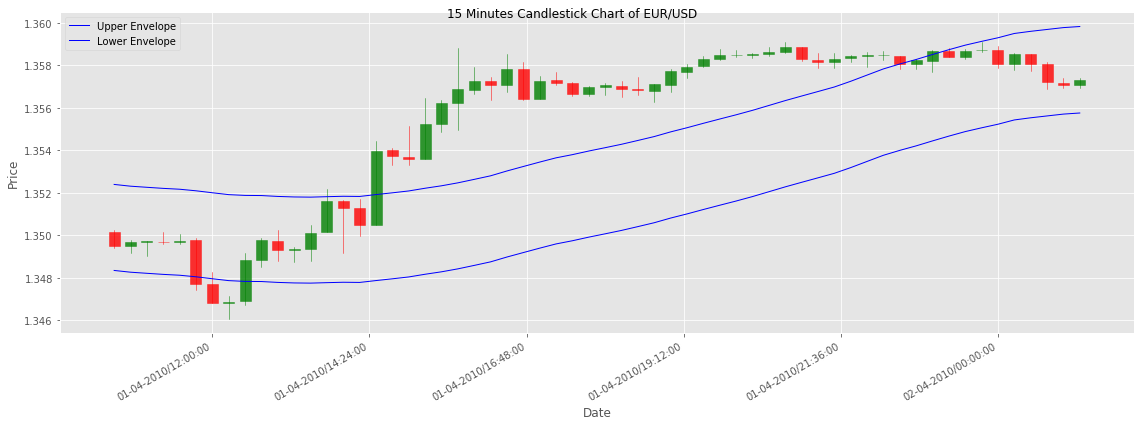

In [13]:
# Creating Subplots
fig, ax = plt.subplots(figsize = (16,6))

candlestick_ohlc(ax, eurusd.iloc[range(60), range(5)].values, width=0.007, colorup='green', colordown='red', alpha=0.8)
ax.plot(eurusd['Time'][:60], eurusd["ul0025"][:60], color = 'blue', linewidth = 1, label='Upper Envelope')
ax.plot(eurusd['Time'][:60], eurusd["ll0025"][:60], color = 'blue', linewidth = 1, label='Lower Envelope')
leg = ax.legend();

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('15 Minutes Candlestick Chart of EUR/USD')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y/%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()

plt.show()

In [14]:
print(eurusd.shape)
print(flag.shape)

(250957, 8)
(250957, 3)


In [15]:
flag["close"] = eurusd["Close"].values

### Strategy 1 - buy from Lower Line and to Upper Line

In [16]:
# Creating boolean values if the below conditions are true
flag["buyTrigger"] = np.where(flag["close"] < flag["ll0025"],1,0)
flag["buyWin"] = np.where(flag["close"] >= flag["ul0025"],1,0)

flag["sellTrigger"] = np.where(flag["close"] > flag["ul0025"],1,0)
flag["sellWin"] = np.where(flag["close"] <= flag["ll0025"],1,0)

flag = flag[["close", "ml", "ll0025", "ul0025", 
             "buyTrigger", "buyWin", 
             "sellTrigger", "sellWin"]]

_We can see that the first buyTrigger=1 is at row 105 and the next column equal 1 is at row 160 where buyWin is triggered, and that's how I defined a winning trade_

In [20]:
flag[100:170]

,close,ml,ll0025,ul0025,buyTrigger,buyWin,sellTrigger,sellWin
100,1.3555,1.3562,1.3541,1.3582,0,0,0,0
101,1.3546,1.3561,1.3541,1.3581,0,0,0,0
102,1.3559,1.3561,1.3540,1.3581,0,0,0,0
103,1.3568,1.3560,1.3540,1.3581,0,0,0,0
104,1.3548,1.3560,1.3539,1.3580,0,0,0,0
105,1.3515,1.3558,1.3538,1.3579,1,0,0,1
106,1.3499,1.3557,1.3536,1.3577,1,0,0,1
107,1.3510,1.3555,1.3535,1.3576,1,0,0,1
108,1.3487,1.3553,1.3533,1.3573,1,0,0,1
109,1.3489,1.3551,1.3531,1.3572,1,0,0,1


_Here I want to delete all the consecutive rows equal to 1 to keep only the first row that becomes equal 1_

In [14]:
flag['buyTrigger'] = flag['buyTrigger'] - flag['buyTrigger'].shift()
flag['buyWin'] = flag['buyWin'] - flag['buyWin'].shift()
flag['buyStopLoss'] = flag['buyStopLoss'] - flag['buyStopLoss'].shift()

flag['sellTrigger'] = flag['sellTrigger'] - flag['sellTrigger'].shift()
flag['sellWin'] = flag['sellWin'] - flag['sellWin'].shift()
flag['sellStopLoss'] = flag['sellStopLoss'] - flag['sellStopLoss'].shift()

_Due to the subtraction of the previous cell now I have rows with -1 that they don't mean anything, so I replace the row equal to -1 with 0_

In [15]:
flag["buyTrigger"] = flag["buyTrigger"].replace(-1, 0)
flag["buyWin"] = flag["buyWin"].replace(-1, 0)
flag["buyStopLoss"] = flag["buyStopLoss"].replace(-1, 0)

flag["sellTrigger"] = flag["sellTrigger"].replace(-1, 0)
flag["sellWin"] = flag["sellWin"].replace(-1, 0)
flag["sellStopLoss"] = flag["sellStopLoss"].replace(-1, 0)

In [16]:
# Some stats
print(flag["buyTrigger"].value_counts())
print(flag["buyWin"].value_counts())
print(flag["buyStopLoss"].value_counts())

print(flag["sellTrigger"].value_counts())
print(flag["sellWin"].value_counts())
print(flag["sellStopLoss"].value_counts())

0.0000    247672
1.0000      3284
Name: buyTrigger, dtype: int64
0.0000    247868
1.0000      3088
Name: buyWin, dtype: int64
0.0000    250879
1.0000        77
Name: buyStopLoss, dtype: int64
0.0000    247868
1.0000      3088
Name: sellTrigger, dtype: int64
0.0000    247672
1.0000      3284
Name: sellWin, dtype: int64
0.0000    250885
1.0000        71
Name: sellStopLoss, dtype: int64


_Here I drop rows with the value 0 on all the boolean columns so that every two rows is the equivalent of a trade_

In [17]:
columns = ["buyTrigger", "buyWin", "buyStopLoss","sellTrigger", "sellStopLoss", "sellWin"]
flag = flag.replace(0, pd.np.nan).dropna(axis=0, how='all', subset=columns).fillna(0)

In [18]:
# Drop the first row, with index=16, because it is a win but it hasn't been triggered at any point
flag = flag.drop(16, axis=0)
flag.index = range(flag.shape[0])
flag.head(5)

,close,ml,ll0025,ul0025,ul01,ll01,buyTrigger,buyStopLoss,buyWin,sellTrigger,sellStopLoss,sellWin
0,1.3515,1.3558,1.3525,1.3592,1.3694,1.3423,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,1.3535,1.3500,1.3467,1.3534,1.3635,1.3365,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000
2,1.3466,1.3508,1.3475,1.3542,1.3644,1.3373,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000
3,1.3521,1.3488,1.3454,1.3521,1.3623,1.3353,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000
4,1.3444,1.3483,1.3449,1.3517,1.3618,1.3348,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000


In [29]:
#Export and Import the dataset
#eurusd.to_csv(os.getcwd()+'\\eurusd15minEnvelopes.csv')
eurusd = pd.read_csv(os.getcwd()+'\\eurusd15minEnvelopes.csv', index_col=0)

#flag.to_csv(os.getcwd()+'\\flagEnvelopes.csv')
flag = pd.read_csv(os.getcwd()+'\\flagEnvelopes.csv', index_col=0)

print(eurusd.shape)
print(flag.shape)

(250957, 10)
(6510, 12)


In [19]:
eurusd.head(5)

,Time,Open,High,Low,Close,ml,ul0025,ll0025,ul01,ll01
0,733863.4375,1.3502,1.3502,1.3494,1.3495,1.3504,1.3537,1.3470,1.3639,1.3369
1,733863.4479,1.3495,1.3498,1.3492,1.3497,1.3503,1.3537,1.3469,1.3638,1.3368
2,733863.4583,1.3497,1.3497,1.3490,1.3497,1.3502,1.3536,1.3469,1.3637,1.3367
3,733863.4688,1.3497,1.3501,1.3496,1.3497,1.3502,1.3536,1.3468,1.3637,1.3367
4,733863.4792,1.3497,1.3500,1.3496,1.3497,1.3501,1.3535,1.3468,1.3636,1.3366


In [20]:
flag.head(5)

,close,ml,ll0025,ul0025,ul01,ll01,buyTrigger,buyStopLoss,buyWin,sellTrigger,sellStopLoss,sellWin
0,1.3515,1.3558,1.3525,1.3592,1.3694,1.3423,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,1.3535,1.3500,1.3467,1.3534,1.3635,1.3365,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000
2,1.3466,1.3508,1.3475,1.3542,1.3644,1.3373,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000
3,1.3521,1.3488,1.3454,1.3521,1.3623,1.3353,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000
4,1.3444,1.3483,1.3449,1.3517,1.3618,1.3348,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000


In [32]:
PL = [0]
pips = 0
entry = 0
exit = 0

for i in range(len(flag.index)-1):
    
    if flag["buyTrigger"][i] == 1 and flag["buyWin"][i+1] == 1:
        entry = flag["close"][i]
        exit = flag["close"][i+1]
        pips = pips + (exit-entry)*10000
        PL.append(pips)
        
    elif flag["buyTrigger"][i] == 1 and flag["buyStopLoss"][i+1] == 1:
        entry = flag["close"][i]
        exit = flag["close"][i+1]
        pips = pips + (exit-entry)*10000
        PL.append(pips)
        
    elif flag["sellTrigger"][i] == 1 and flag["sellWin"][i+1] == 1:
        entry = flag["close"][i]
        exit = flag["close"][i+1]
        pips = pips + (entry-exit)*10000
        PL.append(pips)

    elif flag["sellTrigger"][i] == 1 and flag["sellStopLoss"][i+1] == 1:
        entry = flag["close"][i]
        exit = flag["close"][i+1]
        pips = pips + (entry-exit)*10000
        PL.append(pips)

In [33]:
PL = pd.Series(PL)
PL.tail(1)

1757   82992.7000
dtype: float64

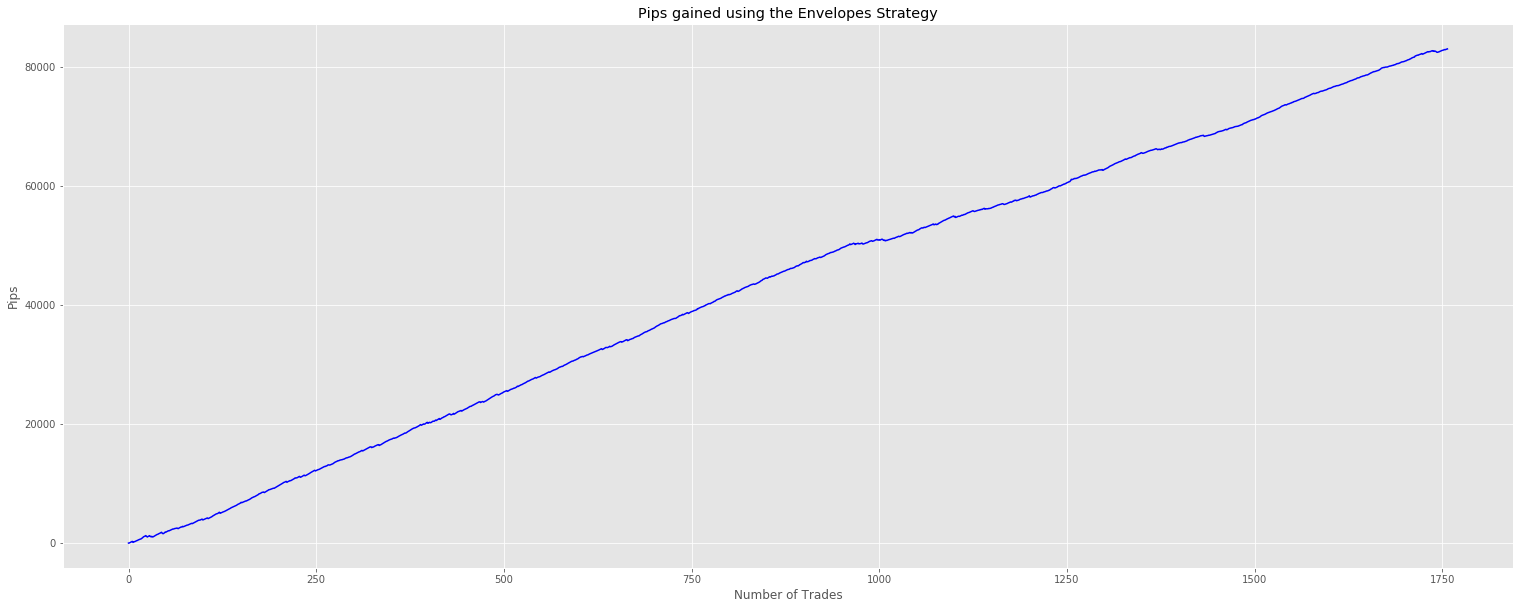

In [34]:
plt.figure(figsize=(26, 10), facecolor='w', edgecolor='k');
PL.plot(color='blue');
plt.title("Pips gained using the Envelopes Strategy", loc='center', pad=None)
plt.ylabel("Pips");
plt.xlabel("Number of Trades");
plt.rcParams.update({'font.size': 20})

### Strategy 2 - buy from Lower Line and to Middle Line

In [35]:
# Loop to create the dataset

Date = pd.Series(datetime.datetime(2010, 4, 1, 0, 0, 0))
eurusd = pd.DataFrame()


while Date.iloc[-1].year != 2020 or Date.iloc[-1].month != 4:
    
    last = Date.iloc[-1]
    inizio = last + datetime.timedelta(minutes=15)
    inizio = zulu.create(inizio.year, inizio.month, inizio.day, inizio.hour, inizio.minute)
    inizio = inizio.isoformat('T')+'Z'
    inizio = str(inizio[:-8] + 'Z')

    params = {
            "from": inizio,
            "granularity": "M15"}

    r = instruments.InstrumentsCandles(instrument="EUR_USD",
                                       params=params)

    rv = client.request(r)

    newDat = []
    for oo in r.response['candles']:
        newDat.append([oo['time'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c']])
    
    newEurusd = pd.DataFrame(newDat)
    newEurusd.columns = ['Time', 'Open', 'High', 'Low', 'Close']
    newEurusd["Time"] = pd.to_datetime(newEurusd['Time'])
    Date = Date.append(newEurusd['Time'])
    newEurusd['Time'] = newEurusd['Time'].apply(mpl_dates.date2num)
    newEurusd = newEurusd.astype(float)
    eurusd = eurusd.append(newEurusd)
    
#Adjusting so that eurusd and Date match
Date = Date.drop(index=0)
eurusd = eurusd.drop(index=0)

eurusd.index = range(eurusd.shape[0])
Date.index = range(eurusd.shape[0])


In [36]:
period, ul0025, ll0025, ml = ENV(eurusd, 40, 0.0025)
period, ul01, ll01, ml = ENV(eurusd, 40, 0.01)

eurusd["ml"] = ml
eurusd["ul0025"] = ul0025
eurusd["ll0025"] = ll0025
eurusd["ul01"] = ul01
eurusd["ll01"] = ll01

eurusd = eurusd.iloc[40:]
eurusd.index = range(eurusd.shape[0])

data = {'ml':ml,'ul0025':ul0025, 'll0025':ll0025,
        'ul01':ul01, 'll01':ll01}

flag = pd.DataFrame(data)

flag.index = range(flag.shape[0])
flag = flag.drop(flag.index[0:period])
flag.index = range(flag.shape[0])

In [37]:
flag["close"] = eurusd["Close"].values
# Creating boolean values if the below conditions are true
flag["buyTrigger"] = np.where(flag["close"] < flag["ll0025"],1,0)
flag["buyStopLoss"] = np.where(flag["close"] < flag["ll01"],1,0)
flag["buyWin"] = np.where(flag["close"] >= flag["ml"],1,0)

flag["sellTrigger"] = np.where(flag["close"] > flag["ul0025"],1,0)
flag["sellStopLoss"] = np.where(flag["close"] > flag["ul01"],1,0)
flag["sellWin"] = np.where(flag["close"] <= flag["ml"],1,0)

flag = flag[["close", "ml", "ll0025", "ul0025", "ul01", "ll01", 
             "buyTrigger", "buyStopLoss", "buyWin", 
             "sellTrigger", "sellStopLoss", "sellWin"]]

In [38]:
flag['buyTrigger'] = flag['buyTrigger'] - flag['buyTrigger'].shift()
flag['buyWin'] = flag['buyWin'] - flag['buyWin'].shift()
flag['buyStopLoss'] = flag['buyStopLoss'] - flag['buyStopLoss'].shift()

flag['sellTrigger'] = flag['sellTrigger'] - flag['sellTrigger'].shift()
flag['sellWin'] = flag['sellWin'] - flag['sellWin'].shift()
flag['sellStopLoss'] = flag['sellStopLoss'] - flag['sellStopLoss'].shift()


flag["buyTrigger"] = flag["buyTrigger"].replace(-1, 0)
flag["buyWin"] = flag["buyWin"].replace(-1, 0)
flag["buyStopLoss"] = flag["buyStopLoss"].replace(-1, 0)

flag["sellTrigger"] = flag["sellTrigger"].replace(-1, 0)
flag["sellWin"] = flag["sellWin"].replace(-1, 0)
flag["sellStopLoss"] = flag["sellStopLoss"].replace(-1, 0)


columns = ["buyTrigger", "buyWin", "buyStopLoss","sellTrigger", "sellStopLoss", "sellWin"]
flag = flag.replace(0, pd.np.nan).dropna(axis=0, how='all', subset=columns).fillna(0)
flag = flag.drop(12, axis=0)
flag.index = range(flag.shape[0])
flag.head(5)

,close,ml,ll0025,ul0025,ul01,ll01,buyTrigger,buyStopLoss,buyWin,sellTrigger,sellStopLoss,sellWin
0,1.3540,1.3499,1.3465,1.3533,1.3634,1.3364,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
1,1.3572,1.3576,1.3543,1.3610,1.3712,1.3441,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2,1.3578,1.3578,1.3544,1.3612,1.3714,1.3442,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
3,1.3570,1.3578,1.3544,1.3612,1.3713,1.3442,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
4,1.3568,1.3560,1.3527,1.3594,1.3696,1.3425,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000


In [39]:
indexToKeep = []
for i in range(len(flag.index)-1):
    if flag["buyTrigger"][i] == 1 and flag["buyWin"][i+1] == 1:
        indexToKeep.append(i)
        indexToKeep.append(i+1)
        
    elif flag["buyTrigger"][i] == 1 and flag["buyStopLoss"][i+1] == 1:
        indexToKeep.append(i)
        indexToKeep.append(i+1)
        
    elif flag["sellTrigger"][i] == 1 and flag["sellWin"][i+1] == 1:
        indexToKeep.append(i)
        indexToKeep.append(i+1)
        
    elif flag["sellTrigger"][i] == 1 and flag["sellStopLoss"][i+1] == 1:
        indexToKeep.append(i)
        indexToKeep.append(i+1)
        
flag = flag.loc[indexToKeep]
flag.index = range(flag.shape[0])
flag.head(10)

,close,ml,ll0025,ul0025,ul01,ll01,buyTrigger,buyStopLoss,buyWin,sellTrigger,sellStopLoss,sellWin
0,1.3540,1.3499,1.3465,1.3533,1.3634,1.3364,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
1,1.3572,1.3576,1.3543,1.3610,1.3712,1.3441,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2,1.3515,1.3558,1.3525,1.3592,1.3694,1.3423,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,1.3504,1.3502,1.3468,1.3536,1.3637,1.3367,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
4,1.3535,1.3500,1.3467,1.3534,1.3635,1.3365,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
5,1.3507,1.3510,1.3476,1.3543,1.3645,1.3375,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
6,1.3466,1.3508,1.3475,1.3542,1.3644,1.3373,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,1.3498,1.3488,1.3454,1.3522,1.3623,1.3353,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
8,1.3521,1.3488,1.3454,1.3521,1.3623,1.3353,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
9,1.3482,1.3486,1.3453,1.3520,1.3621,1.3351,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


In [40]:
PL = [0]
pips = 0
entry = 0
exit = 0

for i in range(len(flag.index)-1):
    
    if flag["buyTrigger"][i] == 1 and flag["buyWin"][i+1] == 1:
        entry = flag["close"][i]
        exit = flag["close"][i+1]
        pips = pips + (exit-entry)*10000
        PL.append(pips)
        
    elif flag["buyTrigger"][i] == 1 and flag["buyStopLoss"][i+1] == 1:
        entry = flag["close"][i]
        exit = flag["close"][i+1]
        pips = pips + (exit-entry)*10000
        PL.append(pips)
        
    elif flag["sellTrigger"][i] == 1 and flag["sellWin"][i+1] == 1:
        entry = flag["close"][i]
        exit = flag["close"][i+1]
        pips = pips + (entry-exit)*10000
        PL.append(pips)

    elif flag["sellTrigger"][i] == 1 and flag["sellStopLoss"][i+1] == 1:
        entry = flag["close"][i]
        exit = flag["close"][i+1]
        pips = pips + (entry-exit)*10000
        PL.append(pips)

In [41]:
PL = pd.Series(PL)
profit = PL.tail(1)
profit

2914   39607.6000
dtype: float64